In [1]:
# Chapter 2 – Cross-League & Multi-Market Efficiency (1X2 & BTTS)
Norway (Eliteserien) · Sweden (Allsvenskan) · Denmark (Superliga) – Season 2025


SyntaxError: invalid character '·' (U+00B7) (ipython-input-3409638369.py, line 2)

Saving Scandanavia.zip to Scandanavia.zip
Market coverage:
                 league  Matches    Markets
0  Allsvenskan (Sweden)      239  1X2, BTTS
1  Eliteserien (Norway)      239  1X2, BTTS
2   Superliga (Denmark)      108  1X2, BTTS 



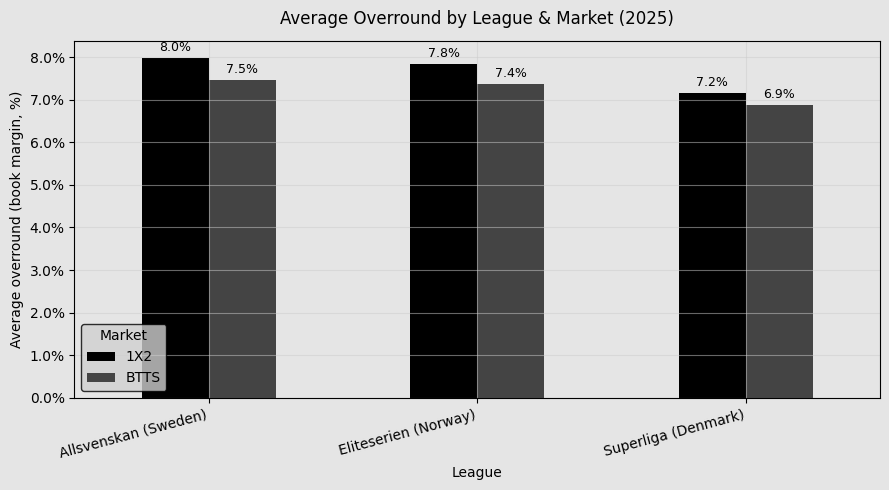

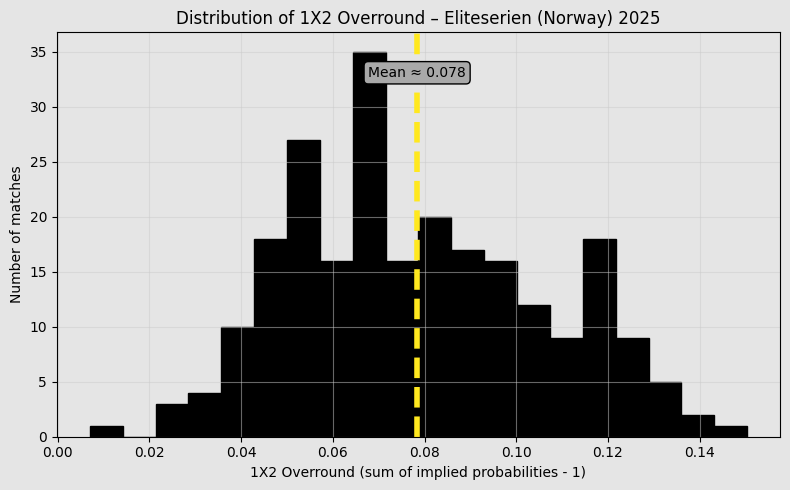

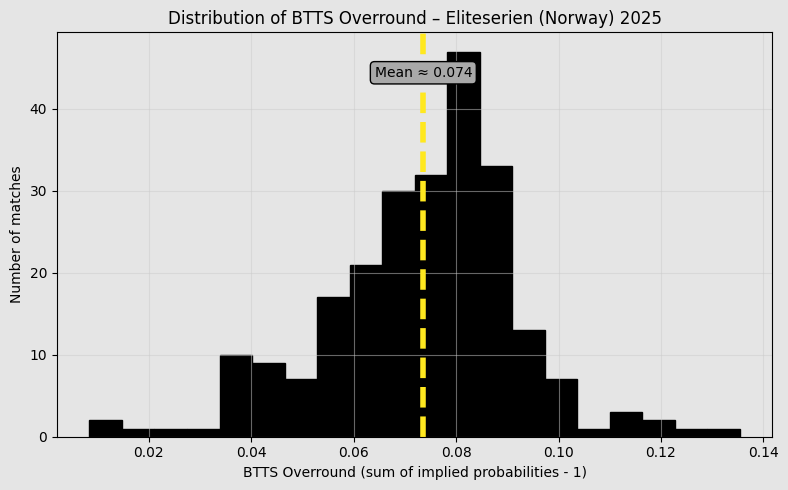

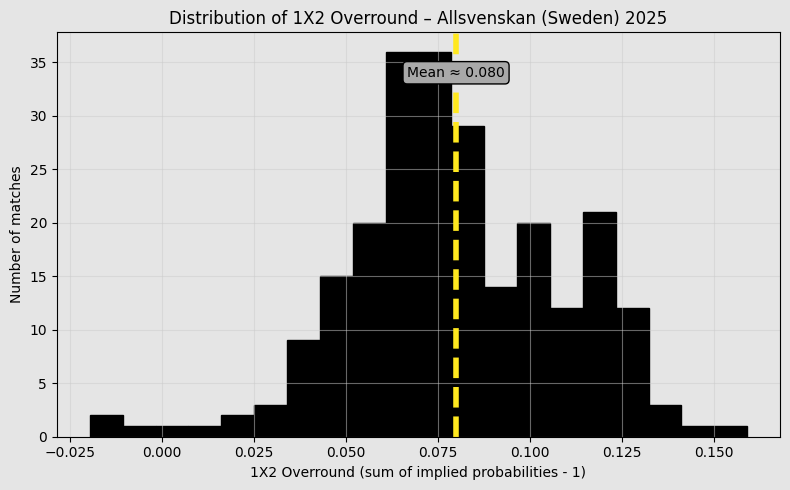

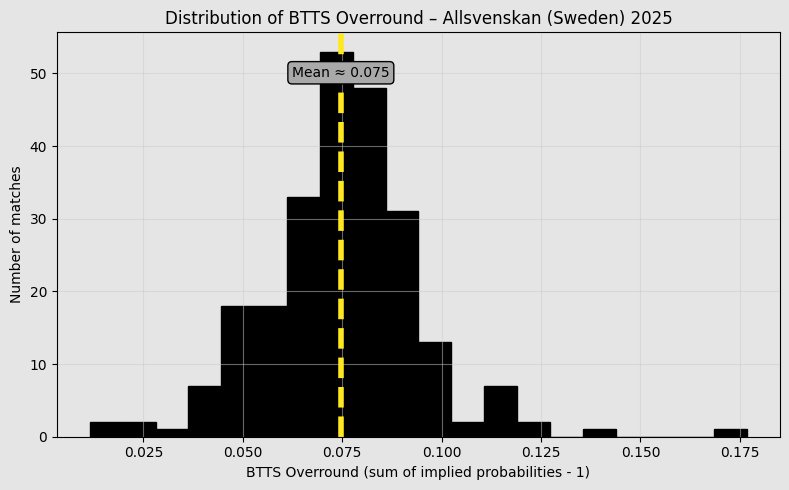

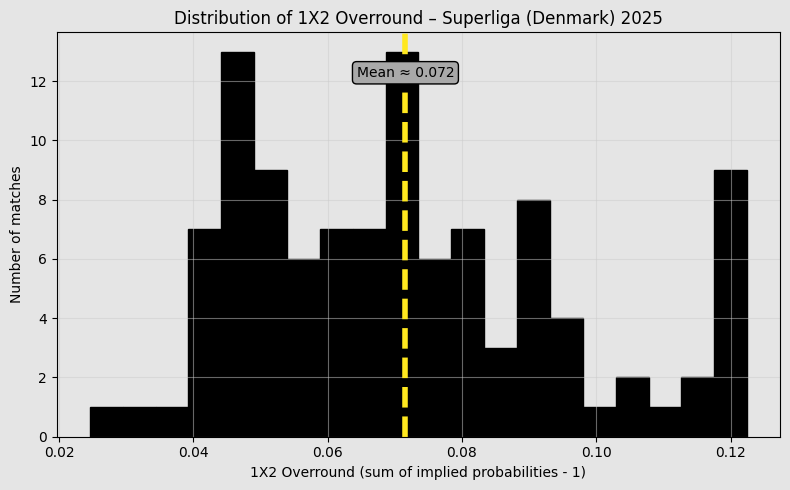

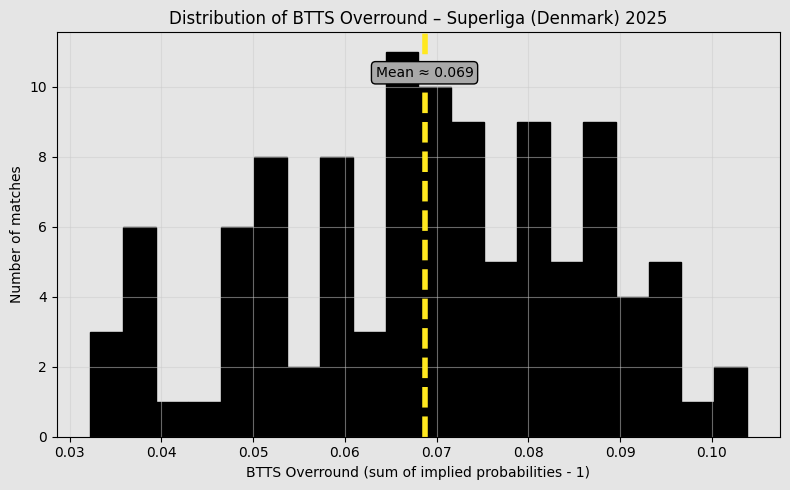

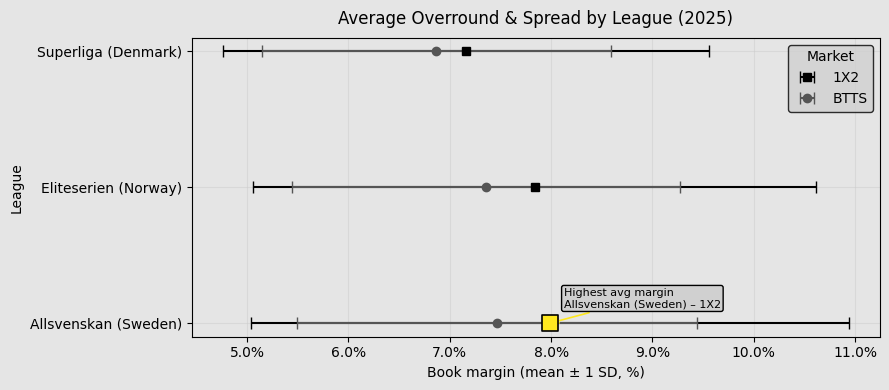

Outcome frequencies (%):
                 league  home_win  draw  away_win  btts_yes_outcome
0  Allsvenskan (Sweden)      39.7  22.2      38.1              52.7
1  Eliteserien (Norway)      48.5  19.2      32.2              57.3
2   Superliga (Denmark)      45.4  19.4      35.2              58.3 

MACE – 1X2 home win:
league
Allsvenskan (Sweden)    0.087633
Eliteserien (Norway)    0.078837
Superliga (Denmark)     0.081099
Name: MACE, dtype: float64 

MACE – BTTS Yes:
league
Allsvenskan (Sweden)    0.021751
Eliteserien (Norway)    0.022372
Superliga (Denmark)     0.091670
Name: MACE, dtype: float64 



/tmp/ipython-input-25857868.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return calib_df.groupby("league").apply(_league_mace).rename("MACE")
/tmp/ipython-input-25857868.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return calib_df.groupby("league").apply(_league_mace).rename("MACE")


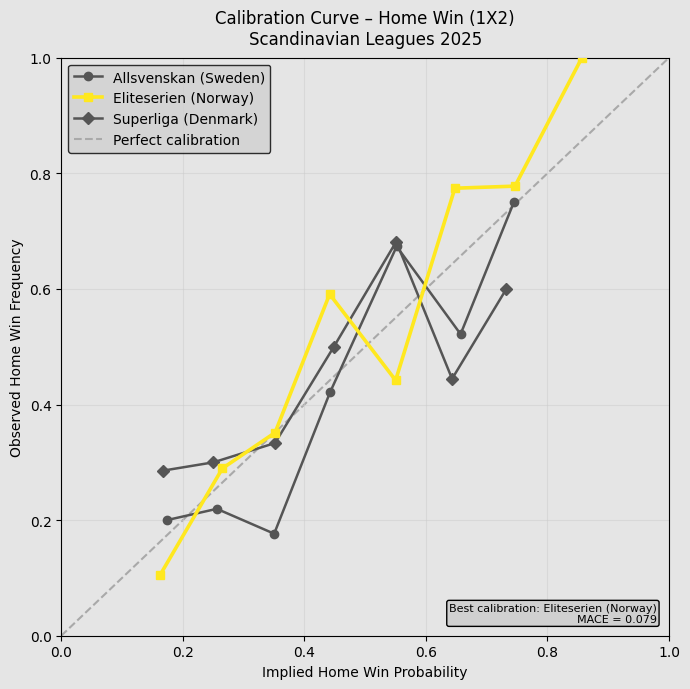

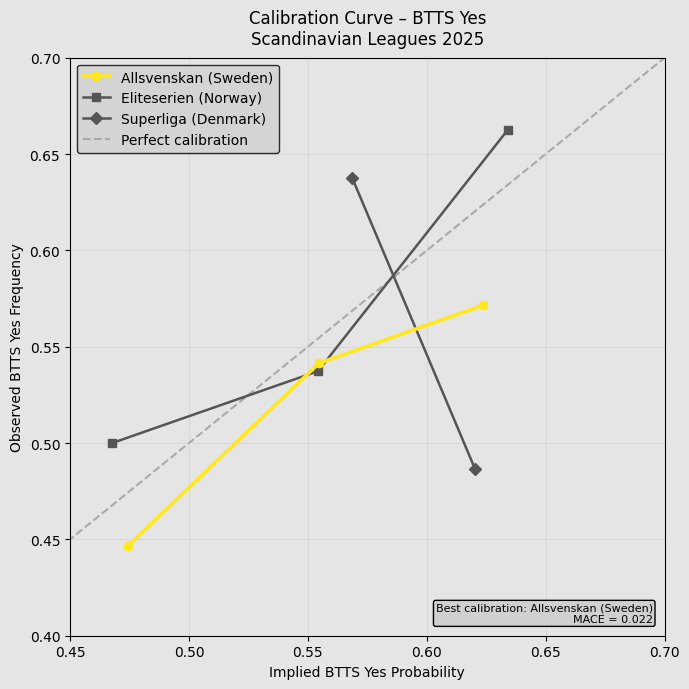

Average Brier scores:
                 league  brier_1x2_home  brier_btts_yes
0  Allsvenskan (Sweden)        0.210685        0.248857
1  Eliteserien (Norway)        0.205404        0.241061
2   Superliga (Denmark)        0.234787        0.247686 



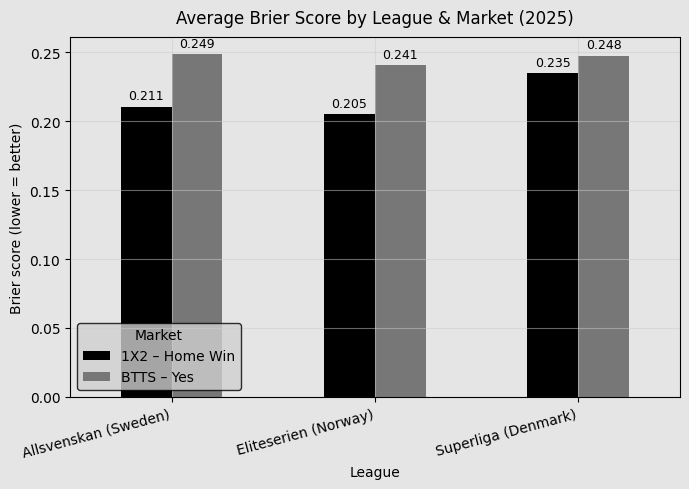

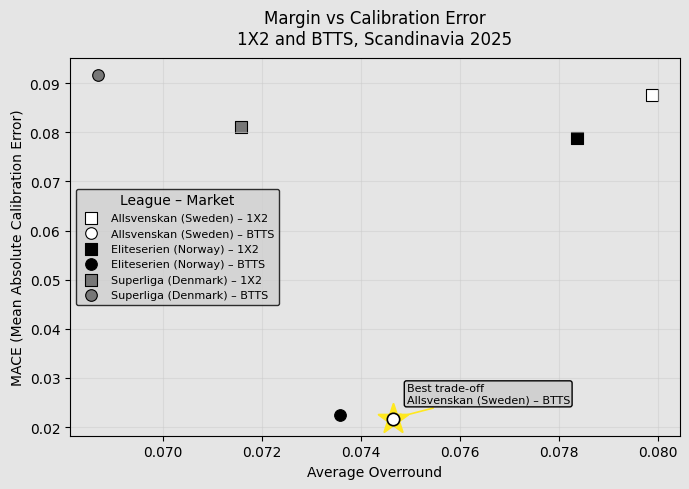

In [2]:
# -*- coding: utf-8 -*-
"""
Chapter 2 – Cross-League & Multi-Market Efficiency (1X2 & BTTS)
Norway (Eliteserien) · Sweden (Allsvenskan) · Denmark (Superliga) – Season 2025
"""

# =============================================================================
# Imports & setup
# =============================================================================
from google.colab import files
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# =============================================================================
# Colour palette & styling helpers
# =============================================================================
GREY_BG     = "#E5E5E5"
GREY_GRID   = "#CCCCCC"
BLACK       = "#000000"
WHITE       = "#FFFFFF"
NEON_YELLOW = "#FFE81F"

def set_fig_bg(fig, color=GREY_BG):
    fig.patch.set_facecolor(color)

def style_light_axes(ax, bg=GREY_BG, text=BLACK, grid_color=GREY_GRID):
    ax.set_facecolor(bg)
    ax.xaxis.label.set_color(text)
    ax.yaxis.label.set_color(text)
    ax.title.set_color(text)
    ax.tick_params(axis="x", colors=text)
    ax.tick_params(axis="y", colors=text)
    for spine in ax.spines.values():
        spine.set_edgecolor(text)
    ax.grid(True, alpha=0.5, color=grid_color)

def plot_overround_hist(league_name, market="1X2", bins=20):
    if market == "1X2":
        col = "overround_1x2"
        mkt_label = "1X2"
        xlabel = "1X2 Overround (sum of implied probabilities - 1)"
    elif market.upper() == "BTTS":
        col = "overround_btts"
        mkt_label = "BTTS"
        xlabel = "BTTS Overround (sum of implied probabilities - 1)"
    else:
        raise ValueError("market must be '1X2' or 'BTTS'")

    subset = df_ch2[df_ch2["league"] == league_name]
    if subset.empty:
        print(f"No data for league: {league_name}")
        return

    mean_or = subset[col].mean()

    fig, ax = plt.subplots(figsize=(8, 5))
    set_fig_bg(fig)
    ax.hist(subset[col], bins=bins, color=BLACK, edgecolor=BLACK)
    ax.axvline(mean_or, color=NEON_YELLOW, linestyle="--", linewidth=4)

    ax.set_title(f"Distribution of {mkt_label} Overround – {league_name} 2025")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of matches")

    style_light_axes(ax)

    ax.text(
        mean_or,
        ax.get_ylim()[1] * 0.9,
        f"Mean ≈ {mean_or:.3f}",
        color=BLACK,
        ha="center",
        va="center",
        bbox=dict(
            facecolor="#A9A9A9",
            edgecolor=BLACK,
            boxstyle="round,pad=0.3",
            alpha=1.0
        )
    )

    plt.tight_layout()
    plt.show()

def calibration_table(df, prob_col, outcome_col, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    tmp = df[["league", prob_col, outcome_col]].copy()
    tmp[prob_col] = tmp[prob_col].clip(0.001, 0.999)
    tmp["prob_bin"] = pd.cut(tmp[prob_col], bins=bins, include_lowest=True)

    calib = (
        tmp
        .groupby(["league", "prob_bin"], observed=True)
        .agg(
            n=("prob_bin", "size"),
            pred_mean=(prob_col, "mean"),
            obs_rate=(outcome_col, "mean")
        )
        .reset_index()
    )

    calib = calib[calib["n"] >= 5].copy()
    calib["bin_low"] = calib["prob_bin"].apply(lambda x: x.left)
    calib["bin_high"] = calib["prob_bin"].apply(lambda x: x.right)

    return calib

def mace_from_calibration(calib_df):
    def _league_mace(g):
        return np.average(
            np.abs(g["obs_rate"] - g["pred_mean"]),
            weights=g["n"]
        )
    return calib_df.groupby("league").apply(_league_mace).rename("MACE")

def market_marker(mkt):
    return "s" if mkt == "1X2" else "o"

# =============================================================================
# 1. Load data from Scandanavia.zip
# =============================================================================
uploaded = files.upload()  # select Scandanavia.zip
zip_path = "Scandanavia.zip"

extract_dir = "/content/scandi_ch2"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

file_map = {
    "Eliteserien (Norway)": "Norway2025.csv",
    "Allsvenskan (Sweden)": "Sweden2025.csv",
    "Superliga (Denmark)": "Denmark2025.csv",
}

dfs = []
for league_name, fname in file_map.items():
    path = os.path.join(extract_dir, fname)
    tmp = pd.read_csv(path)

    tmp_std = pd.DataFrame({
        "league": league_name,
        "season": 2025,
        "home_team": tmp["home_team_name"],
        "away_team": tmp["away_team_name"],
        "home_goals": tmp["home_team_goal_count"],
        "away_goals": tmp["away_team_goal_count"],
        "odds_home": tmp["odds_ft_home_team_win"],
        "odds_draw": tmp["odds_ft_draw"],
        "odds_away": tmp["odds_ft_away_team_win"],
        "odds_btts_yes": tmp["odds_btts_yes"],
        "odds_btts_no": tmp["odds_btts_no"],
    })

    dfs.append(tmp_std)

df = pd.concat(dfs, ignore_index=True)

# =============================================================================
# 2. Basic cleaning & market coverage
# =============================================================================
mask_valid = (
    df["odds_home"].notna() &
    df["odds_draw"].notna() &
    df["odds_away"].notna() &
    df["odds_btts_yes"].notna() &
    df["odds_btts_no"].notna() &
    (df["odds_home"] > 1.0) &
    (df["odds_draw"] > 1.0) &
    (df["odds_away"] > 1.0) &
    (df["odds_btts_yes"] > 1.0) &
    (df["odds_btts_no"] > 1.0)
)

df_ch2 = df[mask_valid].copy()

scope_table = (
    df_ch2
    .groupby("league")
    .size()
    .reset_index(name="Matches")
)
scope_table["Markets"] = "1X2, BTTS"
print("Market coverage:")
print(scope_table, "\n")

# =============================================================================
# 3. Implied probabilities & overrounds
# =============================================================================
# 1X2
for side in ["home", "draw", "away"]:
    df_ch2[f"p1x2_{side}_raw"] = 1.0 / df_ch2[f"odds_{side}"]

df_ch2["sum_1x2_raw"] = (
    df_ch2["p1x2_home_raw"] +
    df_ch2["p1x2_draw_raw"] +
    df_ch2["p1x2_away_raw"]
)
df_ch2["overround_1x2"] = df_ch2["sum_1x2_raw"] - 1.0

for side in ["home", "draw", "away"]:
    df_ch2[f"p1x2_{side}"] = df_ch2[f"p1x2_{side}_raw"] / df_ch2["sum_1x2_raw"]

# BTTS
df_ch2["pbtts_yes_raw"] = 1.0 / df_ch2["odds_btts_yes"]
df_ch2["pbtts_no_raw"]  = 1.0 / df_ch2["odds_btts_no"]
df_ch2["sum_btts_raw"]  = df_ch2["pbtts_yes_raw"] + df_ch2["pbtts_no_raw"]
df_ch2["overround_btts"] = df_ch2["sum_btts_raw"] - 1.0

df_ch2["pbtts_yes"] = df_ch2["pbtts_yes_raw"] / df_ch2["sum_btts_raw"]
df_ch2["pbtts_no"]  = df_ch2["pbtts_no_raw"]  / df_ch2["sum_btts_raw"]

# long format for overrounds
overround_long = pd.DataFrame({
    "league": np.concatenate([df_ch2["league"].values,
                              df_ch2["league"].values]),
    "market": (["1X2"] * len(df_ch2) +
               ["BTTS"] * len(df_ch2)),
    "overround": pd.concat(
        [df_ch2["overround_1x2"], df_ch2["overround_btts"]],
        ignore_index=True
    )
})

overround_summary = (
    overround_long
    .groupby(["league", "market"])["overround"]
    .agg(["mean", "median", "std"])
    .reset_index()
)

# =============================================================================
# 4. Average overround by league & market (bar chart)
# =============================================================================
pivot_or = overround_summary.pivot(index="league", columns="market", values="mean")

fig, ax = plt.subplots(figsize=(9, 5))
set_fig_bg(fig)
pivot_or.plot(kind="bar", ax=ax, color=[BLACK, "#444444"])

ax.set_title("Average Overround by League & Market (2025)", pad=12)
ax.set_xlabel("League")
ax.set_ylabel("Average overround (book margin, %)")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

plt.xticks(rotation=15, ha="right")
style_light_axes(ax)

leg = ax.legend(title="Market", frameon=True)
frame = leg.get_frame()
frame.set_facecolor("#D0D0D0")
frame.set_edgecolor(BLACK)

for container in ax.containers:
    labels = [f"{v * 100:.1f}%" for v in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3, fontsize=9, color=BLACK)

plt.tight_layout()
plt.show()

# =============================================================================
# 5. Overround distributions (histograms, optional)
# =============================================================================
for lg in df_ch2["league"].unique():
    plot_overround_hist(lg, market="1X2",  bins=20)
    plot_overround_hist(lg, market="BTTS", bins=20)

# =============================================================================
# 6. Overround & spread (mean ± 1 SD) with neon highlight
# =============================================================================
summary_spread = overround_summary.copy()
summary_spread["mean_pct"] = summary_spread["mean"] * 100
summary_spread["std_pct"]  = summary_spread["std"] * 100

fig, ax = plt.subplots(figsize=(9, 4))
set_fig_bg(fig)

styles = {
    "1X2":  {"color": BLACK,     "marker": "s"},
    "BTTS": {"color": "#555555", "marker": "o"},
}

for mkt, sty in styles.items():
    d = summary_spread[summary_spread["market"] == mkt]
    ax.errorbar(
        d["mean_pct"],
        d["league"],
        xerr=d["std_pct"],
        fmt=sty["marker"],
        color=sty["color"],
        ecolor=sty["color"],
        elinewidth=1.5,
        capsize=4,
        label=mkt,
    )

idx_hi = summary_spread[summary_spread["market"] == "1X2"]["mean_pct"].idxmax()
hi = summary_spread.loc[idx_hi]

ax.scatter(
    hi["mean_pct"],
    hi["league"],
    s=140,
    marker="s",
    color=NEON_YELLOW,
    edgecolor=BLACK,
    linewidth=1.2,
    zorder=5,
    label="_nolegend_",
)

ax.annotate(
    f"Highest avg margin\n{hi['league']} – {hi['market']}",
    xy=(hi["mean_pct"], hi["league"]),
    xytext=(10, 10),
    textcoords="offset points",
    va="bottom",
    fontsize=8,
    arrowprops=dict(arrowstyle="->", color=NEON_YELLOW, lw=1.2),
    bbox=dict(
        facecolor="#D0D0D0",
        edgecolor=BLACK,
        boxstyle="round,pad=0.2",
    ),
)

ax.set_title("Average Overround & Spread by League (2025)", pad=10)
ax.set_xlabel("Book margin (mean ± 1 SD, %)")
ax.set_ylabel("League")
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=1))
style_light_axes(ax)

leg = ax.legend(title="Market", frameon=True, loc="upper right")
frame = leg.get_frame()
frame.set_facecolor("#D0D0D0")
frame.set_edgecolor(BLACK)

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Outcome flags & frequencies
# =============================================================================
df_ch2["home_win"] = (df_ch2["home_goals"] > df_ch2["away_goals"]).astype(int)
df_ch2["draw"]     = (df_ch2["home_goals"] == df_ch2["away_goals"]).astype(int)
df_ch2["away_win"] = (df_ch2["home_goals"] < df_ch2["away_goals"]).astype(int)

df_ch2["btts_yes_outcome"] = (
    (df_ch2["home_goals"] > 0) & (df_ch2["away_goals"] > 0)
).astype(int)

freq = (
    df_ch2
    .groupby("league")[["home_win", "draw", "away_win", "btts_yes_outcome"]]
    .mean()
    .reset_index()
)

freq_percent = freq.copy()
for col in ["home_win", "draw", "away_win", "btts_yes_outcome"]:
    freq_percent[col] = (freq_percent[col] * 100).round(1)

print("Outcome frequencies (%):")
print(freq_percent, "\n")

# =============================================================================
# 8. Calibration curves (1X2 & BTTS) with MACE
# =============================================================================
calib_1x2_home = calibration_table(df_ch2, "p1x2_home", "home_win", n_bins=10)
calib_btts_yes = calibration_table(df_ch2, "pbtts_yes", "btts_yes_outcome", n_bins=10)

mace_1x2  = mace_from_calibration(calib_1x2_home)
mace_btts = mace_from_calibration(calib_btts_yes)

best_1x2_league  = mace_1x2.idxmin()
best_btts_league = mace_btts.idxmin()

print("MACE – 1X2 home win:")
print(mace_1x2, "\n")
print("MACE – BTTS Yes:")
print(mace_btts, "\n")

# --- Home win (1X2) calibration curve ---
fig, ax = plt.subplots(figsize=(7, 7))
set_fig_bg(fig)

markers = ["o", "s", "D"]
leagues = sorted(calib_1x2_home["league"].unique())

for marker, league in zip(markers, leagues):
    g = (
        calib_1x2_home[calib_1x2_home["league"] == league]
        .sort_values("pred_mean")
    )
    if league == best_1x2_league:
        line_color = NEON_YELLOW
        lw = 2.6
        z = 4
    else:
        line_color = "#555555"
        lw = 1.8
        z = 3

    ax.plot(
        g["pred_mean"],
        g["obs_rate"],
        marker=marker,
        linestyle="-",
        linewidth=lw,
        color=line_color,
        label=league,
        zorder=z,
    )

ax.plot([0, 1], [0, 1], linestyle="--", color="#A9A9A9",
        linewidth=1.5, label="Perfect calibration", zorder=1)

ax.set_title("Calibration Curve – Home Win (1X2)\nScandinavian Leagues 2025", pad=10)
ax.set_xlabel("Implied Home Win Probability")
ax.set_ylabel("Observed Home Win Frequency")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
style_light_axes(ax)

leg = ax.legend(frameon=True, loc="upper left")
frame = leg.get_frame()
frame.set_facecolor("#D0D0D0")
frame.set_edgecolor(BLACK)

best_val = mace_1x2[best_1x2_league]
ax.text(
    0.98, 0.02,
    f"Best calibration: {best_1x2_league}\nMACE = {best_val:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=8,
    bbox=dict(
        facecolor="#D0D0D0",
        edgecolor=BLACK,
        boxstyle="round,pad=0.2",
    ),
)

plt.tight_layout()
plt.show()

# --- BTTS Yes calibration curve ---
fig, ax = plt.subplots(figsize=(7, 7))
set_fig_bg(fig)

for marker, league in zip(markers, leagues):
    g = (
        calib_btts_yes[calib_btts_yes["league"] == league]
        .sort_values("pred_mean")
    )
    if league == best_btts_league:
        line_color = NEON_YELLOW
        lw = 2.6
        z = 4
    else:
        line_color = "#555555"
        lw = 1.8
        z = 3

    ax.plot(
        g["pred_mean"],
        g["obs_rate"],
        marker=marker,
        linestyle="-",
        linewidth=lw,
        color=line_color,
        label=league,
        zorder=z,
    )

ax.plot([0, 1], [0, 1], linestyle="--", color="#A9A9A9",
        linewidth=1.5, label="Perfect calibration", zorder=1)

ax.set_title("Calibration Curve – BTTS Yes\nScandinavian Leagues 2025", pad=10)
ax.set_xlabel("Implied BTTS Yes Probability")
ax.set_ylabel("Observed BTTS Yes Frequency")
ax.set_xlim(0.45, 0.7)
ax.set_ylim(0.4, 0.7)
style_light_axes(ax)

leg = ax.legend(frameon=True, loc="upper left")
frame = leg.get_frame()
frame.set_facecolor("#D0D0D0")
frame.set_edgecolor(BLACK)

best_val_btts = mace_btts[best_btts_league]
ax.text(
    0.98, 0.02,
    f"Best calibration: {best_btts_league}\nMACE = {best_val_btts:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=8,
    bbox=dict(
        facecolor="#D0D0D0",
        edgecolor=BLACK,
        boxstyle="round,pad=0.2",
    ),
)

plt.tight_layout()
plt.show()

# =============================================================================
# 9. Brier scores (table + bar chart)
# =============================================================================
df_ch2["brier_1x2_home"] = (df_ch2["home_win"] - df_ch2["p1x2_home"])**2
df_ch2["brier_btts_yes"] = (df_ch2["btts_yes_outcome"] - df_ch2["pbtts_yes"])**2

brier = (
    df_ch2
    .groupby("league")[["brier_1x2_home", "brier_btts_yes"]]
    .mean()
    .reset_index()
)
print("Average Brier scores:")
print(brier, "\n")

brier_long = brier.melt(
    id_vars="league",
    var_name="metric",
    value_name="brier_score"
)
brier_long["market"] = brier_long["metric"].map({
    "brier_1x2_home": "1X2 – Home Win",
    "brier_btts_yes": "BTTS – Yes",
})

fig, ax = plt.subplots(figsize=(7, 5))
set_fig_bg(fig)

pivot_brier = brier_long.pivot(index="league", columns="market", values="brier_score")
pivot_brier.plot(kind="bar", ax=ax, color=[BLACK, "#777777"])

ax.set_title("Average Brier Score by League & Market (2025)", pad=10)
ax.set_xlabel("League")
ax.set_ylabel("Brier score (lower = better)")
style_light_axes(ax)
plt.xticks(rotation=15, ha="right")

leg = ax.legend(title="Market", frameon=True)
frame = leg.get_frame()
frame.set_facecolor("#D0D0D0")
frame.set_edgecolor(BLACK)

for container in ax.containers:
    labels = [f"{v:.3f}" for v in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3, fontsize=9, color=BLACK)

plt.tight_layout()
plt.show()

# =============================================================================
# 10. Margin vs Calibration Error scatter (1X2 & BTTS)
# =============================================================================
or_mean = (
    overround_long
    .groupby(["league", "market"])["overround"]
    .mean()
    .rename("avg_overround")
    .reset_index()
)

mace_long = pd.DataFrame({
    "league": list(mace_1x2.index) + list(mace_btts.index),
    "market": ["1X2"] * len(mace_1x2) + ["BTTS"] * len(mace_btts),
    "MACE":   np.concatenate([mace_1x2.values, mace_btts.values]),
})

summary = or_mean.merge(mace_long, on=["league", "market"], how="inner")

fig, ax = plt.subplots(figsize=(7, 5))
set_fig_bg(fig)

league_colors = {
    "Allsvenskan (Sweden)": WHITE,
    "Eliteserien (Norway)": BLACK,
    "Superliga (Denmark)":  "#777777",
}

for _, row in summary.iterrows():
    face = league_colors[row["league"]]
    ax.scatter(
        row["avg_overround"],
        row["MACE"],
        marker=market_marker(row["market"]),
        facecolor=face,
        edgecolor=BLACK,
        s=70,
        linewidth=0.8,
        label=f"{row['league']} – {row['market']}",
    )

idx_best = summary["MACE"].idxmin()
best = summary.loc[idx_best]
x_best = best["avg_overround"]
y_best = best["MACE"]
mkt_best = best["market"]

ax.scatter(
    x_best,
    y_best,
    s=500,
    marker="*",
    facecolor=NEON_YELLOW,
    edgecolor=NEON_YELLOW,
    linewidth=1.5,
    zorder=5,
)
ax.scatter(
    x_best,
    y_best,
    s=80,
    marker=market_marker(mkt_best),
    facecolor=WHITE,
    edgecolor=BLACK,
    linewidth=1.2,
    zorder=6,
)

ax.annotate(
    f"Best trade-off\n{best['league']} – {best['market']}",
    xy=(x_best, y_best),
    xytext=(10, 10),
    textcoords="offset points",
    fontsize=8,
    va="bottom",
    bbox=dict(
        facecolor="#D0D0D0",
        edgecolor=BLACK,
        boxstyle="round,pad=0.2",
    ),
    arrowprops=dict(arrowstyle="->", color=NEON_YELLOW, lw=1.2),
)

ax.set_title("Margin vs Calibration Error\n1X2 and BTTS, Scandinavia 2025", pad=10)
ax.set_xlabel("Average Overround")
ax.set_ylabel("MACE (Mean Absolute Calibration Error)")
style_light_axes(ax)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
leg = ax.legend(
    unique.values(),
    unique.keys(),
    frameon=True,
    loc="center left",
    title="League – Market",
    fontsize=8,
)
frame = leg.get_frame()
frame.set_facecolor("#D0D0D0")
frame.set_edgecolor(BLACK)

plt.tight_layout()
plt.show()
